This notebook is a simple example of how to use the `AnnubesEnv` class to create a custom environment and use it to train a reinforcement learning agent with `stable_baselines3`.

## `AnnubesEnv` environment

Let's create an environment, check it works and visualize it.


In [140]:
import neurogym as ngym
from neurogym.envs.annubes import AnnubesEnv
from stable_baselines3.common.env_checker import check_env

env = AnnubesEnv()

# check the custom environment and output additional warnings (if any)
check_env(env)

# check the environment with a random agent
obs, info = env.reset()
n_steps = 10
for _ in range(n_steps):
    # random action
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated:
        obs, info = env.reset()

print(env.timing)
print("----------------")
print(env.observation_space)
print(env.observation_space.name)
print("----------------")
print(env.action_space)
print(env.action_space.name)

{'fixation': 500, 'stimulus': 1000, 'iti': 0}
----------------
Box(0.0, 1.0, (4,), float32)
{'fixation': 0, 'start': 1, 'v': 2, 'a': 3}
----------------
Discrete(2)
{'fixation': 0, 'choice': [1]}


In [141]:
print(env.observation_space.sample())
model.predict(obs)

[0.5521595  0.5082685  0.85527426 0.5743526 ]


(array(0), None)

In [143]:
obs, info = env.reset()

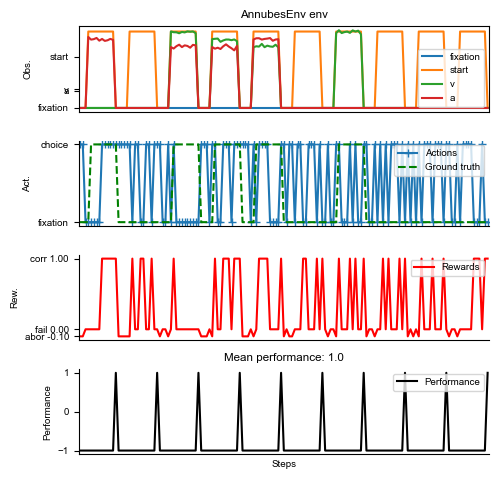

In [144]:
fig = ngym.utils.plot_env(
    env,
    ob_traces=["fixation", "start", "v", "a"],
    num_trials=10
)

## Training `AnnubesEnv`

### 1. Regular training

We can train `AnnubesEnv` using one of the models defined in `stable_baselines3`, for example [`A2C`](https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html).


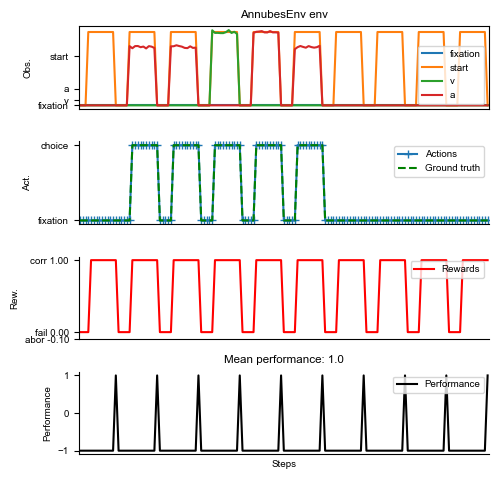

In [145]:
import warnings

from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv

warnings.filterwarnings("default")

# train agent
env = AnnubesEnv()
env_vec = DummyVecEnv([lambda: env])
model = A2C("MlpPolicy", env_vec, verbose=0)
model.learn(total_timesteps=20000, log_interval=1000)
env_vec.close()

# plot example trials with trained agent
data = ngym.utils.plot_env(env, num_trials=10, ob_traces=["fixation", "start", "v", "a"], model=model)

# Creating the output for the Psychometric curve

Now we have a model that can perfom given an environment.
For the psychometric curve we need to test the ability of the model, or the performance/ percentage of being correct, depending on different inputs
Thus, What we need to do is creating a range of inputs, and loop over them. for each input we need about 100 trials to get some good statistics
After the loop we need a list of inputs and the percentage of being correct for each input. From this list we can create the psychometric curve by plotting the inputs against the performance.


In [162]:
import numpy as np
import matplotlib.pyplot as plt

def psychometric_dict(env, model, variables, trials_per_var=11, steps_per_trial=100):
    """
    Runs the model over multiple variables and stimulus intensities, collecting performance statistics.

    Parameters:
    - env: The environment where the model runs.
    - model: The trained model.
    - variables: List of variables (e.g., ["auditory", "visual", "combined"]).
    - trials_per_var: Number of trials per variables.
    - steps_per_trial: Number of steps per trial.

    Returns:
    - results: Nested dictionary with structure:
        {
            "auditory": {stim_intensity: accuracy},
            "visual": {stim_intensity: accuracy},
            "combined": {stim_intensity: accuracy}
        }
    """
    results = {var: {} for var in variables}
    stim_intensities = np.linspace(0.0, 1, trials_per_var)  # Avoid zero intensity
    print(f'stim_intensities: {stim_intensities}')

    # Loop over variables
    for var in variables:
        [print(f'variables: {var}')]

        # Set session configuration based on variables
        if var == "auditory":
            session_config = {"v": 0, "a": 1}
        elif var == "visual":
            session_config = {"v": 1, "a": 0}
        elif var == "combined":
            session_config = {"v": 0.5, "a": 0.5}

        # Loop over stimulus intensities
        for index, stim in enumerate(stim_intensities):
            print(f'stim_intensity: {stim}, index: {index}')

            # Initialize counters that starts at zero for each stimulus intensity
            correct_actions = 0
            stim_trials = 0

            # Set the session and stimulus intensity for the environment
            env.session = session_config  # Ensure `session` is a dictionary
            env.stim_intensities = [float(stim), float(stim)]  # Ensure list format of a float

            # Reset environment
            obs, info = env.reset()

            # Loop over steps per trial (#100)
            for _ in range(steps_per_trial):
                action, _ = model.predict(obs)  # Get action from model
                obs, reward, terminated, truncated, info = env.step(action) # Perform action

                if env.in_period("stimulus"):  # Only count stimulus periods
                    stim_trials += 1
                    if action == env.gt_now:
                        correct_actions += 1

                if terminated:
                    break

            # Compute accuracy
            accuracy = correct_actions / stim_trials if stim_trials > 0 else 0
            results[var][stim] = accuracy * 100  # Convert to percentage

    return results


In [153]:
def plot_psychometric_curve(results):
    """
    Plots psychometric curves for different modalities.

    Args:
        results: Nested dictionary {modality: {stim_intensity: accuracy}}.
    """
    plt.figure(figsize=(8, 6))

    for modality, intensities in results.items():
        stim_values = sorted(intensities.keys())  # Sort by stimulus intensity
        accuracies = [intensities[s] for s in stim_values]

        plt.plot(stim_values, accuracies, marker='o', linestyle='-', label=f'Modality: {modality}')

    plt.xlabel("Stimulus Intensity")
    plt.ylabel("Accuracy (%)")
    plt.title("Psychometric Curve of Agent Performance")
    plt.legend()
    plt.grid()
    plt.show()

# Example usage:
# env = AnnubesEnv()
# model = YourRLAgent()
# results = psychometric_dict(env, model, modalities=["auditory", "visual", "combined"])
# plot_psychometric_curve(results)


In [163]:
variables = ["auditory", "visual", "combined"]

# Run model trials and collect performance data
performance_results = psychometric_dict(env, model, variables)
# print(performance_results)
# print(performance_results['auditory'])
# print(list(performance_results['auditory'].keys()))

print(performance_results.items())

# Plot the psychometric curve
plot_psychometric_curve(performance_results)

stim_intensities: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
variables: auditory
stim_intensity: 0.0, index: 0


TypeError: list indices must be integers or slices, not str

### 2. Sequential training

We can also train `AnnubesEnv` using a sequential training approach. This is useful when we want to train the agent in multiple stages, each with a different environment configuration. This can be useful for:

- **Curriculum learning**: Gradually increase the difficulty of the environments. Start with simpler tasks and progressively move to more complex ones, allowing the agent to build on its previous experiences.

- **Domain randomization**: Vary the environment dynamics (e.g., physics, obstacles) during training to improve the agent's robustness to changes in the environment.

- **Transfer learning**: If you have access to different agents or architectures, you can use transfer learning techniques to fine-tune the model on a new environment.

In this case it is important to include all the possible observations in each environment, even if not all of them are used. This is because the model is initialized with the first environment's observation space and it is not possible to change it later.


In [161]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_modality_performance(env, model, modalities=["auditory", "visual"],
                                  stim_intensities=np.arange(0, 1.1, 0.1),
                                  steps_per_trial=100):
    """
    Evaluates model performance for each modality (auditory and visual) across different stimulus intensities.

    Args:
    - env: The environment (AnnubesEnv)
    - model: The trained RL model
    - modalities: List of modalities to test ["auditory", "visual"]
    - stim_intensities: List of stimulus intensities (default: [0, 0.1, ..., 1])
    - steps_per_trial: Number of steps per intensity level (default: 100)

    Returns:
    - performance_results: Nested dictionary with accuracy per modality and intensity.
    """

    performance_results = {}

    for modality in modalities:
        performance_results[modality] = {}  # Initialize modality results
        session = {"v": 1, "a": 0} if modality == "visual" else {"v": 0, "a": 1}
        env.session = session  # Set environment session for current modality

        print(f"\n🔍 Evaluating modality: {modality} (Session: {session})\n")

        for intensity in stim_intensities:
            correct_actions = 0  # Track correct actions
            total_steps = 0  # Track total observations (steps)

            env.stim_intensities = [intensity, intensity]  # Apply same intensity to both modalities
            obs, info = env.reset()  # Reset environment for new trial

            for _ in range(steps_per_trial):
                action, _ = model.predict(obs)  # Get action from model
                obs, reward, terminated, truncated, info = env.step(action)  # Execute action

                # ✅ Check if action was correct
                if "gt" in info and action == info["gt"]:
                    correct_actions += 1
                total_steps += 1

                if terminated:
                    break  # Stop trial if it's done

            # Compute accuracy
            accuracy = correct_actions / total_steps if total_steps > 0 else 0.0
            performance_results[modality][intensity] = accuracy
            print(f"Stimulus Intensity: {intensity:.1f} | Accuracy: {accuracy:.2%}")

    return performance_results

# Run the function to collect performance data
performance_results = evaluate_modality_performance(env, model, modalities, steps_per_trial=100)

# ✅ Display results in a table format
df = pd.DataFrame.from_dict(performance_results, orient='index').transpose()
print(df)

# ✅ Plot the psychometric curve
plt.figure(figsize=(8, 5))
for modality, accuracy_data in performance_results.items():
    intensities = list(accuracy_data.keys())
    accuracies = list(accuracy_data.values())
    plt.plot(intensities, accuracies, marker="o", label=f"{modality.capitalize()}")

plt.xlabel("Stimulus Intensity")
plt.ylabel("Performance (Accuracy)")
plt.title("Psychometric Curve for Auditory vs. Visual Modalities")
plt.legend()
plt.grid(True)
plt.show()



🔍 Evaluating modality: auditory (Session: {'v': 0, 'a': 1})



TypeError: list indices must be integers or slices, not str

In [ ]:
env1 = AnnubesEnv({"v": 1, "a": 0})
env1_vec = DummyVecEnv([lambda: env1])
# create a model and train it with the first environment
model = A2C("MlpPolicy", env1_vec, verbose=0)
model.learn(total_timesteps=10000)
env1_vec.close()

# plot example trials with trained agent
data = ngym.utils.plot_env(env1, num_trials=10, ob_traces=["fixation", "start", "v", "a"], model=model)

In [ ]:
# switch to the second environment and continue training
env2 = AnnubesEnv({"v": 0, "a": 1})
env2_vec = DummyVecEnv([lambda: env2])
# set the model's environment to the new environment
model.set_env(env2_vec)
model.learn(total_timesteps=10000)
env2_vec.close()

# plot example trials with trained agent
data = ngym.utils.plot_env(env2, num_trials=10, ob_traces=["fixation", "start", "v", "a"], model=model)

In [ ]:
# Switch to the third environment and finish training
env3 = AnnubesEnv({"v": 0.5, "a": 0.5})
env3_vec = DummyVecEnv([lambda: env3])
# set the model's environment to the new environment
model.set_env(env3_vec)
model.learn(total_timesteps=20000)
env3_vec.close()

# plot example trials with trained agent
data = ngym.utils.plot_env(env3, num_trials=10, ob_traces=["fixation", "start", "v", "a"], model=model)

In [ ]:
# Save the final model after all training
model.save("final_model")